In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
from scipy.stats import ttest_ind
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from lifelines.statistics import logrank_test
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from glob import glob
from scipy import stats

In [2]:
pheno_cols = ["ADP_FIB","TRAP_FIB"]
EUR_path_interval = "%s/genetic_score/EUR_interval" % export_folder

## Export Interval european IDs (no need to re-run)

In [25]:
INTERVAL_path = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only"
pheno = pd.read_csv("%s/interval_phenotypes/INTERVALdata_14MAY2020.csv" % INTERVAL_path,sep=",", encoding = "ISO-8859-1")

In [28]:
pheno = pheno.loc[pheno.ethnicPulse == "Eng/W/Scot/NI/Brit"]
pheno.shape

(41527, 760)

In [29]:
matching = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_phenotypes/INTERVAL_OmicsMap_20200514.csv", sep=",")

In [45]:
EUR_interval_list = pd.merge(pheno,matching,left_on="identifier",right_on="identifier")["Affymetrix_QC_bl"].dropna().astype(int).unique().tolist()

In [48]:
with open(EUR_path_interval,"w") as file:
    for s in EUR_interval_list:
        file.write("%s\t%s\n" % (s,s))

# Load GWAS

In [3]:
tag = "5mars"

In [4]:
gws = []
#for c in tqdm(pheno_cols):
for c in tqdm(pheno_cols):
    gw = pd.read_csv("%s/%s/bolt_res_feb_%s" % (export_folder,tag,c),sep="\t")
    gw["pheno"] = c
    gw.P_BOLT_LMM = gw.P_BOLT_LMM.astype(float)
    gws.append(gw)
gw = pd.concat(gws,axis=0,copy=False)
gw.rename(columns={"P_BOLT_LMM":"P"},inplace=True)

100%|██████████| 2/2 [00:23<00:00, 11.53s/it]


In [5]:
gw["POS"] = gw["BP"]
for ch in range(1,23):
    gw.loc[gw.CHR > ch,"POS"] += gw.loc[gw.CHR == ch,"BP"].max()
gw_ = gw.loc[gw.P < 1e-3]

In [6]:
UKBB_SNPS = []
for chrom in tqdm(range(1,23)):
    with open("%s/UKBB_SNPS_CHR%d.snplist" % (export_folder, chrom)) as f:
        UKBB_SNPS += [c[:-1] for c in f.readlines()]

print(len(UKBB_SNPS))
print(UKBB_SNPS[:10])

gw_["IN_UKBB"] = gw_.SNP.isin(UKBB_SNPS)
print(gw_["IN_UKBB"].mean())

100%|██████████| 22/22 [01:26<00:00,  3.93s/it]


93095623
['rs367896724', 'rs540431307', 'rs201106462', 'rs548419688', 'rs568405545', 'rs534229142', 'rs537182016', 'rs572818783', 'rs538322974', '1:10616_CCGCCGTTGCAAAGGCGCGCCG_C']
0.9280581305265407


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


# Prepare data for causal selection

In [7]:
tag = "5mars"
cov = pd.read_csv("%s/%s/covars.csv" % (export_folder, tag), sep="\t")
phenotypes = pd.read_csv("%s/%s/phenotypes.csv" % (export_folder, tag), sep="\t")

phenotypes["ID"] = phenotypes["FID"].astype(str) + "_" + phenotypes["IID"].astype(str)
phenotypes = phenotypes.set_index("ID")[pheno_cols]

cov["ID"] = cov["FID"].astype(str) + "_" + cov["IID"].astype(str)
covar_cols = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PLT","MPV","IPF","PCT","PDW","Sex","age_covar","cohort_covar"]
cov = cov.set_index("ID")[covar_cols]

X = pd.merge(cov,phenotypes,left_index=True,right_index=True)

In [8]:
cov.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PLT,MPV,IPF,PCT,PDW,Sex,age_covar,cohort_covar
ID,,,,,,,,,,,,,,,,,,
110000305926_110000305926,0.001051,-0.005030,0.000366,-0.000485,0.003907,-0.001036,0.003214,0.007618,-0.000403,-0.004247,274.0,10.6,1.9,0.28,12.3,2.0,0.152542,0
110000305952_110000305952,-0.000064,-0.000603,0.000856,0.006369,-0.002127,0.006433,0.001969,-0.000814,-0.000623,0.001776,258.0,10.6,1.7,0.25,13.0,1.0,0.203390,0
110000315493_110000315493,0.001009,0.004312,-0.009543,0.008209,0.002722,0.004606,0.004591,0.006361,0.002414,0.001101,213.0,11.8,2.2,0.26,14.9,1.0,0.470339,0
110000315494_110000315494,0.006815,0.000915,0.006795,-0.005582,-0.005617,0.001646,0.000007,0.000766,0.007461,0.002496,277.0,12.0,4.6,0.33,14.4,2.0,0.487288,0
110000315495_110000315495,0.006833,0.003003,0.002493,0.000562,0.008410,0.002672,0.010753,0.005626,0.001188,0.000879,199.0,12.2,8.5,0.24,15.9,1.0,-0.322034,0


In [9]:
phenotypes.head()

,ADP_FIB,TRAP_FIB
ID,,
110000305926_110000305926,0.450182,0.157353
110000305952_110000305952,0.348209,0.062163
110000315493_110000315493,1.109334,0.227460
110000315494_110000315494,0.387218,-0.111896
110000315495_110000315495,0.395256,0.031637


# Do causal selection

In [10]:
from scipy.stats import pearsonr, levene

In [11]:
def get_p_value(source,target):
    lm = LinearRegression().fit(source,target)
    return pearsonr(target,lm.predict(source))[1]

In [12]:
def compare_p_values(X,model,augmented_model,Y):
    lm1 = LinearRegression().fit(X[model],Y)
    lm2 = LinearRegression().fit(X[augmented_model],Y)
    
    fit_1 = lm1.predict(X[model])
    fit_2 = lm2.predict(X[augmented_model])
    
    #residuals_1 = Y-fit_1
    #residuals_2 = Y-fit_2
    
    #p_val = levene(residuals_1,residuals_2,center="mean")[1]
    p_val = levene(fit_1,fit_2,center="mean")[1]
    
    return p_val

In [92]:
gw.sort_values("P").head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF,P,pheno,POS
4897307,rs6993770,8,106581528,0,A,T,0.715596,0.006605,0.033260,0.003018,3.100000e-28,9.200000e-29,TRAP_FIB,1499032756
4897307,rs6993770,8,106581528,0,A,T,0.715596,0.006605,0.050480,0.004762,3.000000e-26,9.600000e-27,ADP_FIB,1499032756
4897310,rs4734879,8,106583124,0,A,G,0.728222,0.008874,0.032153,0.003067,1.000000e-25,3.300000e-26,TRAP_FIB,1499034352
4897298,rs7832219,8,106578977,0,T,C,0.728564,0.011246,0.032056,0.003069,1.600000e-25,5.000000e-26,TRAP_FIB,1499030205
4897275,rs2343592,8,106572270,0,A,G,0.736865,0.014294,0.032404,0.003107,1.800000e-25,5.400000e-26,TRAP_FIB,1499023498


In [13]:
max_distance = 5e6 # from Dragana's
significant_SNPs = {}
P_threshold = 1e-8
genotypes = {}
for c in pheno_cols:
    print("Starting causal SNPs extraction")
    print(c)
    significant_SNPs[c] = []
    d = gw_.loc[gw_.pheno == c]
    hits = d.loc[(d.P < P_threshold) & (d.IN_UKBB)].copy()
    hits["region"] = AgglomerativeClustering(n_clusters=None,distance_threshold=max_distance,linkage="single")\
                        .fit(np.reshape(hits.POS.values,(-1,1)))\
                        .labels_
    for region, h in hits.groupby("region"):
        print("Region %d" % region)
        #if h.shape[0] == 1:
        #    significant_SNPs[c].append(h["SNP"].iloc[0])
        #    continue
        
        # Write the list of SNPS to a file
        SNP_list_file = "%s/conditional_analysis/significant_snps_%s_%s.txt" % (export_folder,c, tag)
        with open(SNP_list_file,"w") as file:
            for s in h.SNP.tolist():
                file.write("%s\n" % s)
        
        # Extract the table
        ch = int(h.CHR.iloc[0])
        gen_path = "%s/conditional_analysis/genotypes_region_%d_%s_CHR_%d" % (export_folder, region, c, ch)
        command = "/home/hv270/plink"
        command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % ch
        command += " --extract %s" % SNP_list_file
        command += " --keep %s" % EUR_path_interval
        command += " --recode A-transpose --out %s" % gen_path
        p = subprocess.Popen(command,shell=True)
        p.wait()
        print("Done exporting genotypes")
        df = pd.read_csv("%s.traw" % (gen_path),sep="\t")
        df = df.set_index("SNP")
        ID_cols = [c for c in df.columns if c not in ["CHR","(C)M","POS","COUNTED","ALT"]]
        df = df[ID_cols].T
        var_cols = df.columns
        
        for var in var_cols:
            df.loc[df[var].isnull(),var] = df.loc[~df[var].isnull(),var].mean()
        
        G_X = pd.merge(df,X.copy(),left_index=True,right_index=True)
        
        G = G_X[var_cols]
        C = G_X[covar_cols]
        Y = G_X[[c]]
        
        # Adjust phenotype by covariates
        lm_covars = LinearRegression().fit(C,Y)
        Y[c] = Y[c] - lm_covars.predict(C)[:,0]
        
        univariable_p_values = [pearsonr(G[snp],Y[c])[1] for snp in G.columns]
        G = G[[G.columns[i] for i in np.argsort(univariable_p_values)]]
        
        model = [G.columns[0]]
        vars_not_in_model = lambda : [v for v in G.columns if v not in model]
        
        while True and (len(vars_not_in_model()) > 0):
            # Augment the model
            addition_p_values = pd.Series(index=vars_not_in_model(),dtype=float)
            for s in addition_p_values.index:
                #print("Trying to add %s" % s)
                LD = False
                for m in model:
                    R_2 = pearsonr(G[m],G[s])[0]**2
                    if R_2 >= 0.9:
                        addition_p_values.loc[s] = 1.
                        LD = True
                if LD: continue
                augmented_model = model + [s]
                addition_p_values.loc[s] = compare_p_values(G,model,augmented_model,Y[c])
            if addition_p_values.min() >= P_threshold:
                #print("Nothing to add, keep %s" % (model))
                break
            else:
                #print("Adding %s" % s)
                model.append(addition_p_values.sort_values().index[0])
            
            # Reduce the model
            reduce = True
            while reduce:
                reduce = False
                removal_p_values = pd.Series(index=model,dtype=float)
                for s in removal_p_values.index:
                    #print("Trying to remove %s" % s)
                    reduced_model = [m for m in model if m != s]
                    removal_p_values.loc[s] = compare_p_values(G,model,reduced_model,Y[c])
                if removal_p_values.min() <= P_threshold:
                    pass
                    # Go to augment
                else:
                    to_remove = removal_p_values.sort_values().index[-1]
                    print("Removing %s" % to_remove)
                    model = [m for m in model if m != to_remove]
                    reduce = True if len(model) >= 2 else False
                    # Go to reduce
        
        significant_SNPs[c] += model
        
        print("Done causal variant extraction. Kept %d out of %d" % (len(model),len(var_cols)))
        print("Hit : ")
        print(h.loc[h.SNP.isin(model),["CHR","BP","SNP","P"]])
        
        genotypes[(c, region)] = G[model]
    

Starting causal SNPs extraction
ADP_FIB
Region 0
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 7
Hit : 
         CHR        BP         SNP             P
8813200   20  57547945   rs6064731  1.200000e-11
8813349   20  57594684  rs34524896  4.300000e-18
Region 1
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 45
Hit : 
        CHR         BP         SNP             P
530956    1  198990494  rs17625587  9.500000e-21
530983    1  199010721   rs1434282  2.300000e-21
Region 2
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 12
Hit : 
         CHR         BP        SNP             P
6725700   12  122365583  rs7961894  8.700000e-19
6725841   12  122401501  rs1169072  6.300000e-09
Region 3
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 61
Hit : 
         CHR        BP         SNP             P
7536861   15  65160392  rs59001897  3.500000e-17
Region 4
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 26
Hit : 
        CHR         BP         SNP             P
556192    1  207281706  rs34101855  2.500000e-17
Region 5
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 9
Hit : 
        CHR         BP         SNP             P
446372    1  171949750  rs10914144  1.900000e-14
Region 6
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 16
Hit : 
         CHR        BP         SNP             P
5639601   10  65027610  rs10761731  4.000000e-10
Region 7
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 106
Hit : 
         CHR         BP        SNP             P
4897307    8  106581528  rs6993770  9.600000e-27
Region 8
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 61
Hit : 
         CHR        BP        SNP             P
7888473   16  81886182  rs7193477  4.200000e-16
Region 9
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 2
Hit : 
         CHR       BP        SNP             P
8206256   18  9620332  rs9807614  9.200000e-09
Region 10
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
         CHR         BP         SNP             P
5329368    9  113312231  rs61751937  6.900000e-11
Region 11
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 503
Hit : 
         CHR         BP        SNP             P
3182577    5  122220665   rs152039  3.200000e-19
3183082    5  122347871  rs2617453  9.500000e-14
Region 12
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 68
Hit : 
         CHR        BP        SNP             P
8620574   19  55538980  rs1654425  3.200000e-15
Region 13
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 78
Hit : 
         CHR         BP         SNP             P
4357695    7  106372219    rs342293  1.800000e-20
4357707    7  106374640  rs12534496  1.300000e-11
Region 14
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
         CHR         BP         SNP             P
5025984    8  145031968  rs55831924  4.100000e-09
Region 15
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
         CHR        BP        SNP             P
1657453    3  56849749  rs1354034  9.200000e-10
Region 16
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 2
Hit : 
         CHR       BP         SNP             P
7946029   17  3819002  rs11078475  2.800000e-09
Region 17
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 2
Hit : 
        CHR         BP         SNP             P
392805    1  156869714  rs12041331  5.000000e-10
Region 18
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 33
Hit : 
         CHR         BP          SNP             P
5768135   10  104330296  rs111763415  2.200000e-09
Region 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
        CHR         BP         SNP             P
698870    1  248020556  rs11204523  4.000000e-09
Starting causal SNPs extraction
TRAP_FIB
Region 0
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 2
Hit : 
         CHR         BP          SNP             P
5328291    9  113099642  rs117149770  4.600000e-09
5329368    9  113312231   rs61751937  2.300000e-11
Region 1
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 68
Hit : 
         CHR         BP          SNP             P
5768135   10  104330296  rs111763415  5.500000e-10
Region 2
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 11
Hit : 
         CHR        BP         SNP             P
5639601   10  65027610  rs10761731  3.200000e-09
Region 3
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 62
Hit : 
         CHR        BP         SNP             P
7536861   15  65160392  rs59001897  3.500000e-18
Region 4
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 12
Hit : 
         CHR         BP        SNP             P
6725700   12  122365583  rs7961894  3.000000e-19
6725841   12  122401501  rs1169072  2.600000e-09
Region 5
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 83
Hit : 
         CHR        BP        SNP             P
8620574   19  55538980  rs1654425  6.600000e-16
Region 6
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 9
Hit : 
        CHR         BP        SNP             P
446356    1  171942783  rs6425521  1.200000e-13
Region 7
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 26
Hit : 
        CHR         BP         SNP             P
556192    1  207281706  rs34101855  2.900000e-17
Region 8
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 62
Hit : 
         CHR        BP        SNP             P
7888473   16  81886182  rs7193477  2.200000e-16
Region 9
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 45
Hit : 
        CHR         BP         SNP             P
530956    1  198990494  rs17625587  2.700000e-21
530983    1  199010721   rs1434282  6.100000e-22
Region 10
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 19
Hit : 
         CHR        BP         SNP             P
8813201   20  57548029    rs467040  4.000000e-09
8813349   20  57594684  rs34524896  1.800000e-21
Region 11
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 511
Hit : 
         CHR         BP        SNP             P
3182577    5  122220665   rs152039  2.300000e-21
3183082    5  122347871  rs2617453  3.000000e-15
Region 12
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
        CHR         BP         SNP             P
698870    1  248020556  rs11204523  3.800000e-09
Region 13
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 2
Hit : 
         CHR      BP          SNP             P
5877442   11  270330  rs117558678  4.000000e-09
Region 14
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 107
Hit : 
         CHR         BP        SNP             P
4897307    8  106581528  rs6993770  9.200000e-29
Region 15
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
         CHR        BP        SNP             P
1657453    3  56849749  rs1354034  8.200000e-11
Region 16
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 2
Hit : 
         CHR       BP         SNP             P
7946029   17  3819002  rs11078475  4.100000e-09
Region 17
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 3
Hit : 
        CHR         BP         SNP             P
392805    1  156869714  rs12041331  1.300000e-10
Region 18
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 78
Hit : 
         CHR         BP         SNP             P
4357695    7  106372219    rs342293  1.200000e-18
4357707    7  106374640  rs12534496  1.600000e-10
Region 19
Done exporting genotypes
Done causal variant extraction. Kept 1 out of 1
Hit : 
         CHR         BP         SNP             P
5025984    8  145031968  rs55831924  4.500000e-09


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
all_significant_SNPs = []
for c in significant_SNPs:
    all_significant_SNPs += significant_SNPs[c]
all_significant_SNPs = list(set(all_significant_SNPs))
recap = pd.DataFrame(index=all_significant_SNPs)
for c in pheno_cols:
    recap["causal_%s" % c] = recap.index.isin(significant_SNPs[c])


In [15]:
gw.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF,P,pheno,POS
0,rs568149713,1,15777,0,A,G,0.991710,0.037767,0.029973,0.023995,0.21,0.25,ADP_FIB,15777
1,rs199745162,1,16949,0,A,C,0.986426,0.047996,-0.003176,0.019029,0.87,0.93,ADP_FIB,16949
2,rs533090414,1,18849,0,C,G,0.023225,0.050571,0.000379,0.014576,0.98,0.98,ADP_FIB,18849
3,rs2691277,1,52238,0,T,G,0.012572,0.050266,-0.021468,0.019518,0.27,0.26,ADP_FIB,52238
4,rs552304420,1,54712,0,T,C,0.993477,0.021136,0.006732,0.026949,0.80,0.85,ADP_FIB,54712


In [16]:
for c in pheno_cols:
    recap = pd.merge(recap,
                     gw.loc[gw.pheno == c,["SNP","BETA","P"]].set_index("SNP").rename(columns={"BETA":"BETA_%s" % c,
                                                                                               "P":"P_%s" % c}),
                     left_index=True,right_index=True)
recap = pd.merge(recap,gw.loc[gw.pheno == pheno_cols[0],["SNP","A1FREQ","CHR","BP"]].set_index("SNP"),left_index=True,right_index=True)

In [17]:
recap.sort_values(["CHR","BP"])

,causal_ADP_FIB,causal_TRAP_FIB,BETA_ADP_FIB,P_ADP_FIB,BETA_TRAP_FIB,P_TRAP_FIB,A1FREQ,CHR,BP
rs12041331,True,True,0.046216,5.000000e-10,0.030246,1.300000e-10,0.913270,1,156869714
rs6425521,False,True,0.040401,2.000000e-14,0.024831,1.200000e-13,0.193286,1,171942783
rs10914144,True,False,0.040385,1.900000e-14,0.024736,1.400000e-13,0.193518,1,171949750
rs17625587,True,True,-0.047149,9.500000e-21,-0.030271,2.700000e-21,0.740589,1,198990494
rs1434282,True,True,0.047447,2.300000e-21,0.030482,6.100000e-22,0.265177,1,199010721
rs34101855,True,True,0.056272,2.500000e-17,0.035586,2.900000e-17,0.880316,1,207281706
rs11204523,True,True,0.030363,4.000000e-09,0.019234,3.800000e-09,0.235326,1,248020556
rs1354034,True,True,-0.026758,9.200000e-10,-0.018014,8.200000e-11,0.405090,3,56849749
rs152039,True,True,-0.040301,3.200000e-19,-0.027035,2.300000e-21,0.331313,5,122220665
rs2617453,True,True,0.033298,9.500000e-14,0.022351,3.000000e-15,0.650532,5,122347871


In [18]:
recap[["causal_ADP_FIB","causal_TRAP_FIB"]].value_counts()

causal_ADP_FIB  causal_TRAP_FIB
True            True               22
False           True                4
True            False               3
dtype: int64

In [19]:
recap["MAF"] = np.where(recap["A1FREQ"] <= .5,recap["A1FREQ"],1.-recap["A1FREQ"])

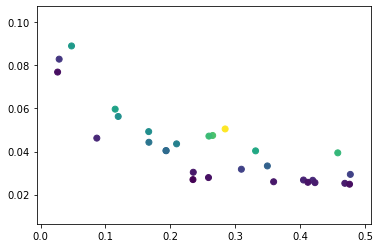

In [20]:
plt.scatter(recap.MAF,np.abs(recap.BETA_ADP_FIB),c=-np.log10(recap.P_ADP_FIB))

# Export causal SNPs

In [21]:
for c in pheno_cols:
    path = "%s/conditional_analysis/causal_SNPs_%s_%s.txt" % (export_folder,tag,c)
    with open(path,"w") as f:
        for snp in significant_SNPs[c]:
            f.write("%s\n" % snp)

In [22]:
path = "%s/conditional_analysis/causal_SNPs_%s_all.txt" % (export_folder,tag)
with open(path,"w") as f:
    for snp in all_significant_SNPs:
        f.write("%s\n" % snp)

# Compare with Dragana's hits

In [23]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [24]:
for CH in range(1,23):
    # Write the list of SNPS to a file
    SNP_list_file = "%s/conditional_analysis/dragana_snps_chr_%d.txt" % (export_folder, CH)
    SNP_list = dgw.loc[(dgw["Chr (GRCh37)"] == CH) & dgw.SNP.str.contains("rs")].SNP.unique().tolist()
    SNP_list = [s for s in SNP_list if "rs" in s]
    with open(SNP_list_file,"w") as file:
        for s in SNP_list:
            file.write("%s\n" % s)

    # Extract the table
    gen_path = "%s/conditional_analysis/genotypes_dragana_CHR_%d" % (export_folder, CH)
    command = "/home/hv270/plink"
    command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % CH
    command += " --extract %s" % SNP_list_file
    command += " --keep %s" % EUR_path_interval
    command += " --recode A-transpose --out %s" % gen_path
    p = subprocess.Popen(command,shell=True)
    p.wait()
    print("Done exporting genotypes of chrom %d" % CH)

Done exporting genotypes of chrom 1
Done exporting genotypes of chrom 2
Done exporting genotypes of chrom 3
Done exporting genotypes of chrom 4
Done exporting genotypes of chrom 5
Done exporting genotypes of chrom 6
Done exporting genotypes of chrom 7
Done exporting genotypes of chrom 8
Done exporting genotypes of chrom 9
Done exporting genotypes of chrom 10
Done exporting genotypes of chrom 11
Done exporting genotypes of chrom 12
Done exporting genotypes of chrom 13
Done exporting genotypes of chrom 14
Done exporting genotypes of chrom 15
Done exporting genotypes of chrom 16
Done exporting genotypes of chrom 17
Done exporting genotypes of chrom 18
Done exporting genotypes of chrom 19
Done exporting genotypes of chrom 20
Done exporting genotypes of chrom 21
Done exporting genotypes of chrom 22


In [25]:
gs = []
for CH in range(1,23):
    gen_path = "%s/conditional_analysis/genotypes_dragana_CHR_%d" % (export_folder, CH)
    df = pd.read_csv("%s.traw" % (gen_path),sep="\t")
    df = df.set_index("SNP")
    ID_cols = [c for c in df.columns if c not in ["CHR","(C)M","POS","COUNTED","ALT"]]
    df = df[ID_cols].T
    gs.append(df)
gen = pd.concat(gs,axis=1)
gen = gen.loc[:,~gen.columns.duplicated(keep="first")]

In [26]:
gen = gen.loc[gen.index.isin(X.index.tolist())]

In [27]:
for c in gen.columns:
    cond = gen[c].isnull()
    gen.loc[cond,c] = gen.loc[~cond,c].mean()

In [28]:
X_G = pd.merge(X, gen,left_index=True,right_index=True)

In [29]:
G_H = pd.concat([genotypes[key] for key in genotypes],axis=1)
G_H = G_H.loc[:,~G_H.columns.duplicated(keep="first")]

In [30]:
X_G_H = pd.merge(X_G,G_H[[s for s in G_H.columns if s not in X_G.columns]],left_index=True,right_index=True)

In [31]:
dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])].SNP.nunique()

2298

In [32]:
new_hits = []

all_d_hits = [s for s in dgw.SNP.unique().tolist() if s in gen.columns]

for pheno in pheno_cols:
    lm = LinearRegression().fit(X_G_H[cov.columns],X_G_H[pheno])
    adj_cov = X_G_H[pheno] - lm.predict(X_G_H[cov.columns])
    N_train = 20000
    for snp in G_H.columns:
        
        candidate_SNPs = dgw.loc[(dgw["Chr (GRCh37)"] == gw_.loc[gw_.SNP == snp,"CHR"].iloc[0])].SNP.unique().tolist()
        candidate_SNPs = [s for s in candidate_SNPs if np.abs(dgw.loc[dgw.SNP == s,"BP (GRCh37)"].iloc[0] - gw_.loc[gw_.SNP == snp,"BP"].mean()) <= 1e8]
        just_neighbors = [s for s in candidate_SNPs if s in gen.columns]
        
        lm1 = LinearRegression().fit(X_G_H[all_d_hits].iloc[:N_train],adj_cov.iloc[:N_train])
        pred1 = lm1.predict(X_G_H[all_d_hits].iloc[N_train:])
        r_1 = pearsonr(pred1,adj_cov.iloc[N_train:])[0]
        
        lm2 = LinearRegression().fit(X_G_H[just_neighbors].iloc[:N_train],adj_cov.iloc[:N_train])
        pred2 = lm2.predict(X_G_H[just_neighbors].iloc[N_train:])
        r_2 = pearsonr(pred2,adj_cov.iloc[N_train:])[0]
        print(r_1,r_2, len(just_neighbors))
        if r_1 < r_2:
            print("Better to take only neighbors")
        snps_to_take = all_d_hits if np.abs(r_2) < np.abs(r_1) else just_neighbors
        
        lm = LinearRegression().fit(X_G_H[snps_to_take],adj_cov)
        adj_D = adj_cov - lm.predict(X_G_H[snps_to_take])
        p = pearsonr(adj_D,X_G_H[snp])[1]
        print("%s - %s - %.2e" % (pheno, snp, p))
        if p < 1e-8 and p not in new_hits:
            new_hits.append(snp)

0.19757022136313768 0.04953064042092656 91
ADP_FIB - rs34524896 - 1.00e+00
0.19757022136313768 0.04953064042092656 91
ADP_FIB - rs6064731 - 2.09e-01
0.19757022136313768 0.10821877105751161 119
ADP_FIB - rs1434282 - 1.00e+00
0.19757022136313768 0.10821877105751161 119
ADP_FIB - rs17625587 - 4.71e-01
0.19757022136313768 0.07655909418163948 89
ADP_FIB - rs7961894 - 6.47e-05
0.19757022136313768 0.07655909418163948 89
ADP_FIB - rs1169072 - 9.14e-06
0.19757022136313768 0.03810846791905927 47
ADP_FIB - rs59001897 - 1.33e-01
0.19757022136313768 0.10821877105751161 119
ADP_FIB - rs34101855 - 3.50e-01
0.19757022136313768 0.107555351041486 133
ADP_FIB - rs10914144 - 9.22e-01
0.19757022136313768 0.028094264420007717 80
ADP_FIB - rs10761731 - 1.00e+00
0.19757022136313768 0.05448530739179522 65
ADP_FIB - rs6993770 - 1.00e+00
0.19757022136313768 0.04615996668191081 83
ADP_FIB - rs7193477 - 1.06e-01
0.19757022136313768 0.026317192619911563 45
ADP_FIB - rs9807614 - 9.28e-01
0.19757022136313768 0.025557

In [88]:
def get_lm_info(X,y,predictions,lm):

    #newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    #MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    params = np.append(lm.intercept_,lm.coef_)
    # Note if you don't want to use a DataFrame replace the two lines above with
    newX = np.append(np.ones((len(X),1)), X, axis=1)
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    #p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P"] = [params,sd_b,ts_b,p_values]
    myDF3["P"] = np.clip(myDF3["P"],a_min=1e-40,a_max=1)
    return myDF3.iloc[1:] # Don't return offset

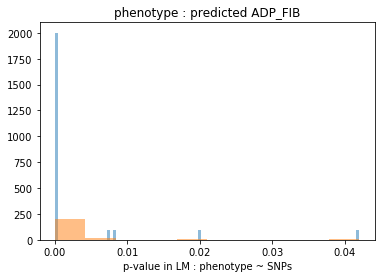

In [89]:
all_d_hits = [s for s in dgw.SNP.unique().tolist() if s in gen.columns]

for pheno in pheno_cols:
    lm = LinearRegression().fit(X_G_H[cov.columns],X_G_H[pheno])
    adj_cov = X_G_H[pheno] - lm.predict(X_G_H[cov.columns])
    
    #all_hits = list(set(all_d_hits + significant_SNPs[pheno]))
    all_hits = significant_SNPs[pheno]
    lm = LinearRegression().fit(X_G_H[all_hits],adj_cov)
    pred = lm.predict(X_G_H[all_hits])
    
    lm_info = get_lm_info(X_G_H[all_hits],adj_cov,pred,lm)
    lm_info["P_alone"] = [pearsonr(X_G_H[s],adj_cov)[1] for s in all_hits]
    lm_info["SNP"] = all_hits
    lm_info.set_index("SNP",inplace=True)
    
    plt.figure()
    plt.hist(lm_info["P"],density=True,bins=100,alpha=.5,label="D SNPs")
    plt.hist(lm_info.loc[significant_SNPs[pheno],"P"],density=True,alpha=.5,label="HV SNPs")
    plt.xlabel("p-value in LM : phenotype ~ SNPs")
    plt.title("phenotype : predicted %s" % pheno)
    break

In [40]:
gw.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF,P,pheno,POS
0,rs568149713,1,15777,0,A,G,0.991710,0.037767,0.029973,0.023995,0.21,0.25,ADP_FIB,15777
1,rs199745162,1,16949,0,A,C,0.986426,0.047996,-0.003176,0.019029,0.87,0.93,ADP_FIB,16949
2,rs533090414,1,18849,0,C,G,0.023225,0.050571,0.000379,0.014576,0.98,0.98,ADP_FIB,18849
3,rs2691277,1,52238,0,T,G,0.012572,0.050266,-0.021468,0.019518,0.27,0.26,ADP_FIB,52238
4,rs552304420,1,54712,0,T,C,0.993477,0.021136,0.006732,0.026949,0.80,0.85,ADP_FIB,54712


In [90]:
illustrate = pd.merge(gw.loc[gw.pheno == pheno],lm_info,left_on="SNP",right_index=True,how="inner")

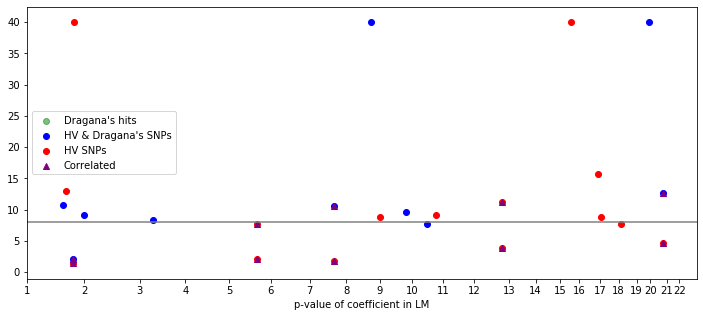

In [100]:
is_HV = illustrate.SNP.isin(significant_SNPs[pheno])
is_D = illustrate.SNP.isin(all_d_hits)
is_corr = illustrate.SNP.isin([significant_SNPs[pheno][i] for i in corr_snps])
plt.figure(figsize=(12,5))
plt.scatter(illustrate.loc[~is_HV,"POS"],-np.log10(illustrate.loc[~is_HV,"P_y"]),c="green",alpha=.5,label="Dragana's hits")
plt.scatter(illustrate.loc[is_HV & is_D,"POS"],-np.log10(illustrate.loc[is_HV & is_D,"P_y"]),c="blue",alpha=1,label="HV & Dragana's SNPs")
plt.scatter(illustrate.loc[is_HV & ~is_D,"POS"],-np.log10(illustrate.loc[is_HV & ~is_D,"P_y"]),c="red",alpha=1,label="HV SNPs")
plt.scatter(illustrate.loc[is_HV & is_corr,"POS"],-np.log10(illustrate.loc[is_HV & is_corr,"P_y"]),c="purple",marker="^",alpha=1,label="Correlated")
plt.axhline(8,c="grey")
plt.xlabel("p-value of coefficient in LM")
plt.xticks([gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)],[str(i) for i in range(1,23)]);
plt.legend();

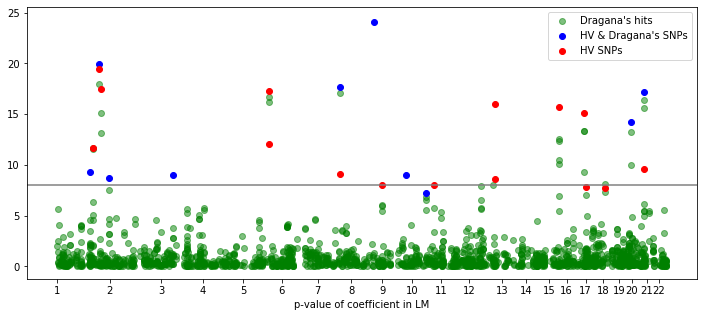

In [47]:
is_HV = illustrate.SNP.isin(significant_SNPs[pheno])
is_D = illustrate.SNP.isin(all_d_hits)
plt.figure(figsize=(12,5))
plt.scatter(illustrate.loc[~is_HV,"POS"],-np.log10(illustrate.loc[~is_HV,"P_alone"]),c="green",alpha=.5,label="Dragana's hits")
plt.scatter(illustrate.loc[is_HV & is_D,"POS"],-np.log10(illustrate.loc[is_HV & is_D,"P_alone"]),c="blue",alpha=1,label="HV & Dragana's SNPs")
plt.scatter(illustrate.loc[is_HV & ~is_D,"POS"],-np.log10(illustrate.loc[is_HV & ~is_D,"P_alone"]),c="red",alpha=1,label="HV SNPs")

plt.axhline(8,c="grey")
plt.xlabel("p-value of coefficient in LM")
plt.xticks([gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)],[str(i) for i in range(1,23)]);
plt.legend();

In [1]:
S = X_G_H[significant_SNPs[pheno]].values
S = S - np.mean(S,axis=0)
corr = np.abs((S.T @ S) / (S.shape[0]**2))
np.fill_diagonal(corr, 0.)

NameError: name 'X_G_H' is not defined

In [82]:
pearsonr(X_G_H[significant_SNPs[pheno][20]],X_G_H[significant_SNPs[pheno][19]])

(0.010882653778507372, 0.0637039133184314)

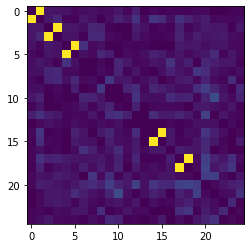

In [93]:
plt.imshow(corr,vmin=0.,vmax=.000001)

In [110]:
pearsonr(X_G_H[significant_SNPs[pheno][0]],X_G_H[significant_SNPs[pheno][1]])[0]**2

0.08023001028246528

In [101]:
corr[np.where(corr > .000001)]

array([1.88253352e-06, 1.88253352e-06, 1.09437382e-05, 1.09437382e-05,
       2.86465029e-06, 2.86465029e-06, 1.43646047e-05, 1.43646047e-05,
       1.41026460e-05, 1.41026460e-05])

In [95]:
corr_snps = np.where(corr > .000001)[0]

# Look in Dragana's GWAS

In [179]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["SNP"].isin(all_significant_SNPs)]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [180]:
dgw.columns

Index(['Associated Blood Index', 'Novel vs Astle 2016', 'Locus ID',
       'Associated Blood Index Class', 'Unique Variant ID', 'Gene', 'SNP',
       'INFO SCORE', 'Chr (GRCh37)', 'BP (GRCh37)', 'REF (GRC37)',
       'ALT (GRC37)', 'Minor Allele', 'Alternative Allele Frequency',
       'Minor Allele Frequency',
       '(UNIVAR) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)',
       '(UNIVAR) Standard Error of Estimator', '(UNIVAR) -log10 P',
       '(UNIVAR) Unadjusted R2',
       '(MULTI) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)',
       '(MULTI) Standard Error of Estimate', '(MULTI) -log10 P',
       'Most Serious VEP Consequence of Variant',
       'VEP IMPACT of Most Serious Consequence',
       'Ensembl Gene ID(s) for Most Serious Consequence'],
      dtype='object')

In [182]:
sysmex_pheno = ~dgw.pivot_table(aggfunc="first",index="SNP",columns="Associated Blood Index",values=["Gene"])["Gene"].isnull()

In [184]:
genes = dgw.groupby("SNP")[["Gene"]].first()

In [185]:
genes

,Gene
SNP,
rs10761731,JMJD1C
rs11204523,TRIM58
rs12041331,PEAR1
rs1354034,ARHGEF3
rs1434282,RP11-16L9.4
rs1654425,GP6
rs34101855,C4BPA
rs342293,CTB-111H14.1
rs34524896,TUBB1


In [187]:
sysmex_pheno["Dragana GWAS traits"] = ""
for c in sysmex_pheno.columns:
    if c == "Dragana GWAS traits": continue
    sysmex_pheno.loc[sysmex_pheno[c],"Dragana GWAS traits"] += "%s " % c

In [188]:
sysmex_pheno["Dragana GWAS traits"]

SNP
rs10761731                                            MPV PLT# 
rs11204523                                             MPV PDW 
rs12041331                                        MPV PDW PLT# 
rs1354034     HLSR# HLSR% LYMPH# LYMPH% MPV PCT PLT# RET# RET% 
rs1434282     HCT HGB HLSR# HLSR% IRF MCH MCV MRV MSCV PCT P...
rs1654425                                                  MPV 
rs34101855                                           RET# RET% 
rs342293                                          MPV PDW WBC# 
rs34524896                                                PLT# 
rs61751937                                             MPV PDW 
rs6993770                                     MPV PCT PDW PLT# 
Name: Dragana GWAS traits, dtype: object

In [190]:
recap = pd.merge(recap,sysmex_pheno[["Dragana GWAS traits"]],how="left",left_index=True,right_index=True).fillna("")

In [192]:
recap.sample(3)

,causal_ADP_FIB,causal_TRAP_FIB,BETA_ADP_FIB,P_ADP_FIB,BETA_TRAP_FIB,P_TRAP_FIB,A1FREQ,CHR,BP,MAF,Dragana GWAS traits
rs6064731,True,False,-0.031769,1.200000e-11,-0.021001,1.600000e-12,0.690579,20,57547945,0.309421,
rs1434282,True,True,0.047447,2.300000e-21,0.030482,6.100000e-22,0.265177,1,199010721,0.265177,HCT HGB HLSR# HLSR% IRF MCH MCV MRV MSCV PCT P...
rs1654425,True,True,-0.044290,3.200000e-15,-0.028800,6.600000e-16,0.166962,19,55538980,0.166962,MPV


In [195]:
import myvariant
mv = myvariant.MyVariantInfo()

gene_names = {}
to_query = recap.index.tolist()
a = mv.querymany(to_query,scopes='dbsnp.rsid', build="hg38",fetchall=False)

for i in range(len(a)):
    q = a[i]["query"]
    try:
        gene = a[i]["cadd"]["gene"]["genename"]
    except:
        try:
            gene = a[i]["dbsnp"]["gene"]["symbol"]
        except:
            try:
                gene = a[i]["wellderly"]["genename"]
            except:
                try:
                    gene = a[i]["snpeff"]["ann"]["genename"]
                except:
                    try:
                        gene = a[i]["snpeff"]["ann"][0]["genename"]
                    except:
                        if q == "rs111763415":
                            gene = "SUFU"
                        else:
                            gene = "not found"
    if q in gene_names:
        gene_names[q].append(gene)
    else:
        gene_names[q] = [gene]

for q in gene_names:
    recap.loc[q,"genes"] = ", ".join(list(set(gene_names[q])))

querying 1-29...done.
Finished.
15 input query terms found dup hits:
	[('rs6425521', 2), ('rs59001897', 2), ('rs117558678', 2), ('rs10914144', 3), ('rs61751937', 2), ('rs
1 input query terms found no hit:
	['rs111763415']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [196]:
recap

,causal_ADP_FIB,causal_TRAP_FIB,BETA_ADP_FIB,P_ADP_FIB,BETA_TRAP_FIB,P_TRAP_FIB,A1FREQ,CHR,BP,MAF,Dragana GWAS traits,genes
rs6425521,False,True,0.040401,2.000000e-14,0.024831,1.200000e-13,0.193286,1,171942783,0.193286,,DNM3
rs59001897,True,True,-0.049245,3.500000e-17,-0.032179,3.500000e-18,0.833369,15,65160392,0.166631,,PLEKHO2
rs117558678,False,True,-0.026954,6.300000e-08,-0.018656,4.000000e-09,0.765168,11,270330,0.234832,,PSMD13-NLRP6
rs10914144,True,False,0.040385,1.900000e-14,0.024736,1.400000e-13,0.193518,1,171949750,0.193518,,DNM3
rs1354034,True,True,-0.026758,9.200000e-10,-0.018014,8.200000e-11,0.405090,3,56849749,0.405090,HLSR# HLSR% LYMPH# LYMPH% MPV PCT PLT# RET# RET%,ARHGEF3
rs61751937,True,True,-0.082894,6.900000e-11,-0.053881,2.300000e-11,0.971285,9,113312231,0.028715,MPV PDW,SVEP1
rs7193477,True,True,-0.043554,4.200000e-16,-0.027859,2.200000e-16,0.790405,16,81886182,0.209595,,PLCG2
rs7961894,True,True,0.059670,8.700000e-19,0.038354,3.000000e-19,0.885004,12,122365583,0.114996,,WDR66
rs6064731,True,False,-0.031769,1.200000e-11,-0.021001,1.600000e-12,0.690579,20,57547945,0.309421,,GNAS-NELFCD
rs342293,True,True,0.039380,1.800000e-20,0.023689,1.200000e-18,0.542087,7,106372219,0.457913,MPV PDW WBC#,CTB-30L5.1


In [200]:
(recap["Dragana GWAS traits"] == "").mean()

0.6206896551724138

In [199]:
recap.to_csv("/home/hv270/sysmex2pf/recap_%s.csv" % tag)

# Manhattan plot

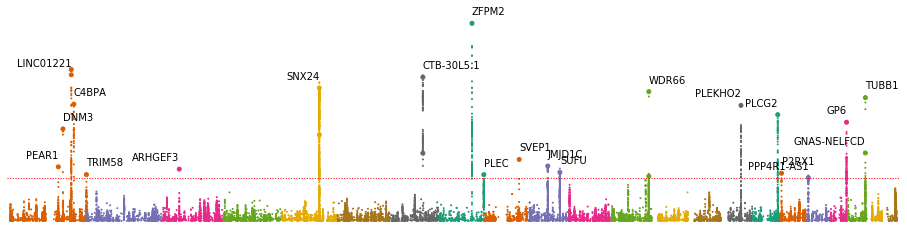

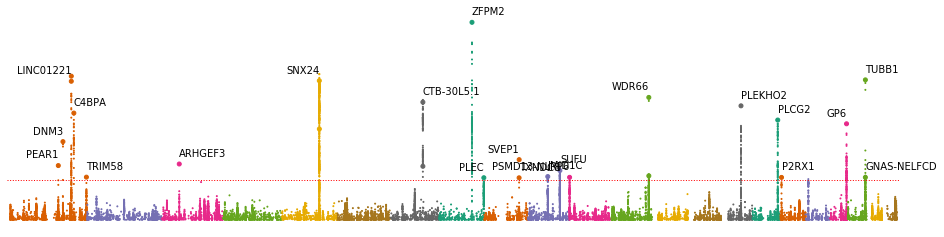

In [237]:
cmap = plt.get_cmap("Dark2")
for c in pheno_cols:
    g = gw_.loc[gw_.pheno == c]
    plt.figure(figsize=(16,4))
    plt.scatter(g.POS,-np.log10(g.P),c=cmap(g.CHR % 8),s=1 + 15*g.SNP.isin(significant_SNPs[c]))
    plt.xticks([g.loc[g.CHR == ch,"POS"].min() for ch in range(1,23)],[str(ch) for ch in range(1,23)])
    plt.axhline(8,c="red",ls=":",lw=1)
    written_genes = []
    for i, snp in enumerate(recap.loc[recap["causal_%s" % c]].index):
        pos = g.loc[g.SNP == snp,"POS"] #+ (i % 2)*1e7 - 5e6
        height = 1 - np.log10(g.loc[g.SNP == snp,"P"])
        gene = recap.loc[snp,"genes"]
        if gene not in written_genes:
            plt.text(pos, height,gene,ha="right" if i % 2 == 0 else "left")
            written_genes.append(gene)
    plt.axis("off")
    plt.xlim((g.POS.min()-1e7,g.POS.max() + 1e7))

0.00099